In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from torchvision.datasets import ImageFolder
import random
import shutil
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [17]:
os.mkdir('train_temp')
os.mkdir('test_temp')

In [18]:
source = 'EuroSAT_RGB'
train_dest = 'train_temp'
test_dest = 'test_temp'

files = os.listdir(source)
files.sort()

image_class = 0
class_dict = {}
for folder_name in files:
    if folder_name[0] != '.':
        images = os.listdir(source + '/' + folder_name)
        sample_size = int(len(images) * 0.8)

        train = []
        final_dest = train_dest + '/' + str(image_class)
        os.mkdir(final_dest)
        for file_name in random.sample(images, sample_size):
            shutil.copy2(os.path.join(source, folder_name, file_name), final_dest)
            train.append(file_name)
        
        test_images = list(set(images) - set(train))
        final_dest = test_dest + '/' + str(image_class)
        os.mkdir(final_dest)
        for test_image in test_images:
            shutil.copy2(os.path.join(source, folder_name, test_image), final_dest)
        
        class_dict[image_class] = folder_name
        image_class += 1

In [19]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.ImageFolder(root='train_temp', transform=transform)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.ImageFolder(root='test_temp', transform=transform)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,shuffle=True, num_workers=2)

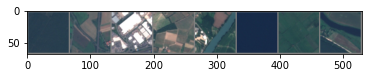

Labels: 1 3 4 6 8 9 5 8


In [3]:
# Function to display a sample of images
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training images and display them
dataiter = iter(train_data_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:8]))
print('Labels:', ' '.join('%d' % labels[j] for j in range(8)))

In [4]:
# Let's define a simple CNN to classify digits

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1)  # in_channels, out_channels, kernel_size, stride
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.conv3 = nn.Conv2d(128, 256, 3, 1)
        self.dropout1 = nn.Dropout(0.25)  # Each channel gets zeroed out independently on each forward call with probability p
        self.dropout2 = nn.Dropout(0.5)
        self.dropout3 = nn.Dropout(0.7)
        self.fc1 = nn.Linear(215296, 2048)
        # self.fc2 = nn.Linear(32768, 128)
        self.fc3 = nn.Linear(2048, 512)
        self.fc4 = nn.Linear(512, 128)
        self.fc5 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        # x = self.fc2(x)
        # x = self.dropout3(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        return F.log_softmax(x, dim=1)

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (dropout3): Dropout(p=0.7, inplace=False)
  (fc1): Linear(in_features=215296, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=10, bias=True)
)


In [5]:
# Set the device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

Epoch 0:   0%|          | 0/338 [00:01<?, ?it/s]

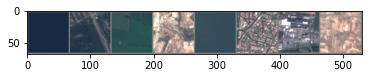

Actual: 9 3 5 6 9 7 4 6
Predicted: 9 9 9 2 2 2 2 9


Epoch 0:  30%|██▉       | 100/338 [06:00<13:49,  3.48s/it]

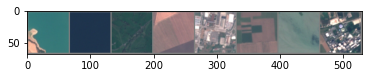

Actual: 9 9 5 0 4 0 9 4
Predicted: 0 1 1 0 4 6 0 4


Epoch 0:  59%|█████▉    | 200/338 [12:11<08:21,  3.63s/it]

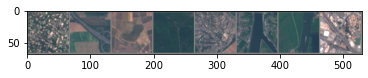

Actual: 7 3 6 1 7 8 8 3
Predicted: 7 0 2 1 7 8 5 7


Epoch 0:  89%|████████▉ | 300/338 [18:11<02:27,  3.89s/it]

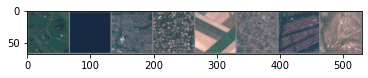

Actual: 5 9 7 7 0 7 7 2
Predicted: 5 9 7 7 0 7 7 6


Epoch 0: 100%|██████████| 338/338 [20:39<00:00,  3.67s/it]


Epoch 1, Loss: 1.1565296213887082


Epoch 1:   0%|          | 0/338 [00:01<?, ?it/s]

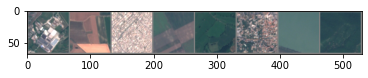

Actual: 4 0 7 0 5 7 9 1
Predicted: 4 0 7 0 5 7 9 5


Epoch 1:  30%|██▉       | 100/338 [06:05<14:01,  3.54s/it]

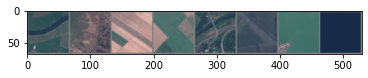

Actual: 8 2 0 0 3 3 9 9
Predicted: 8 2 0 0 3 8 9 9


Epoch 1:  59%|█████▉    | 200/338 [12:08<08:50,  3.85s/it]

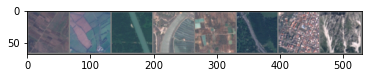

Actual: 6 5 8 8 6 3 7 2
Predicted: 2 0 8 6 6 8 7 4


Epoch 1:  89%|████████▉ | 300/338 [18:05<02:17,  3.61s/it]

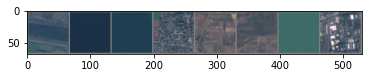

Actual: 8 9 9 7 6 2 9 4
Predicted: 8 9 9 7 6 2 9 4


Epoch 1: 100%|██████████| 338/338 [20:30<00:00,  3.64s/it]


Epoch 2, Loss: 0.6471633868934834


Epoch 2:   0%|          | 0/338 [00:01<?, ?it/s]

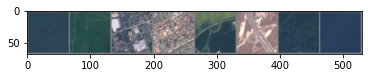

Actual: 1 5 4 7 3 3 1 9
Predicted: 9 5 7 7 6 7 1 9


Epoch 2:  30%|██▉       | 100/338 [06:05<14:16,  3.60s/it]

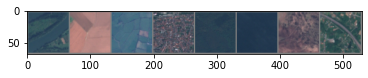

Actual: 8 0 5 7 1 9 2 3
Predicted: 8 0 5 7 1 9 2 3


Epoch 2:  59%|█████▉    | 200/338 [11:59<08:08,  3.54s/it]

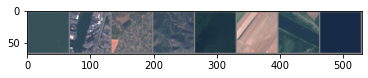

Actual: 9 8 7 2 1 0 8 9
Predicted: 9 4 7 2 1 0 8 9


Epoch 2:  89%|████████▉ | 300/338 [17:52<02:14,  3.55s/it]

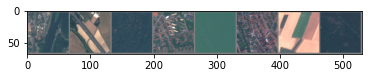

Actual: 8 3 1 7 9 7 0 1
Predicted: 8 3 1 7 9 7 0 1


Epoch 2: 100%|██████████| 338/338 [20:16<00:00,  3.60s/it]


Epoch 3, Loss: 0.49131569103681233


Epoch 3:   0%|          | 0/338 [00:01<?, ?it/s]

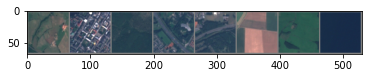

Actual: 5 7 1 3 3 0 5 9
Predicted: 5 4 1 8 8 0 5 9


Epoch 3:  30%|██▉       | 100/338 [05:57<13:45,  3.47s/it]

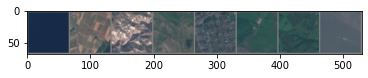

Actual: 9 6 2 2 7 5 5 9
Predicted: 9 6 2 5 7 5 5 9


Epoch 3:  59%|█████▉    | 200/338 [12:03<08:11,  3.56s/it]

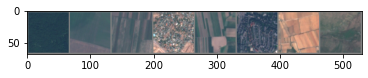

Actual: 1 0 0 7 0 7 6 2
Predicted: 1 0 2 7 0 7 0 2


Epoch 3:  89%|████████▉ | 300/338 [18:14<02:18,  3.64s/it]

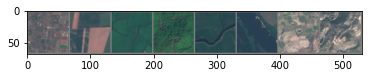

Actual: 6 0 5 1 8 8 6 2
Predicted: 2 0 5 1 3 8 6 2


Epoch 3: 100%|██████████| 338/338 [20:42<00:00,  3.68s/it]


Epoch 4, Loss: 0.33246835310198913


Epoch 4:   0%|          | 0/338 [00:01<?, ?it/s]

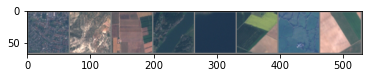

Actual: 7 2 6 8 9 0 5 0
Predicted: 7 2 0 8 9 0 5 0


Epoch 4:  30%|██▉       | 100/338 [06:20<14:33,  3.67s/it]

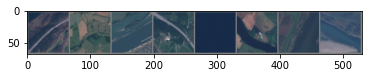

Actual: 3 5 8 3 9 8 8 8
Predicted: 3 6 8 3 9 8 8 8


Epoch 4:  59%|█████▉    | 200/338 [12:36<09:06,  3.96s/it]

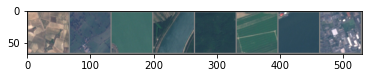

Actual: 6 5 9 8 1 0 9 4
Predicted: 6 8 9 8 1 0 9 4


Epoch 4:  89%|████████▉ | 300/338 [18:56<02:27,  3.89s/it]

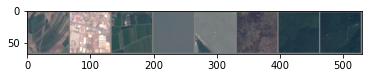

Actual: 6 4 6 9 9 2 1 1
Predicted: 6 4 3 9 9 2 1 1


Epoch 4: 100%|██████████| 338/338 [21:27<00:00,  3.81s/it]


Epoch 5, Loss: 0.22276383629590712
Finished Training


In [6]:
# Number of training epochs
num_epochs = 5

testiter = iter(test_data_loader)
# Main training loop
for epoch in range(num_epochs):
    running_loss = 0.0

    i = 0
    for data in (pbar := tqdm(train_data_loader)):
        pbar.set_description(f"Epoch {epoch}")
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        total_correct = 0
        total_samples = 0
        if i % 100 == 0:
            with torch.no_grad():
                # Show a sample of images from the test data and model's predictions
                test_images, test_labels = next(testiter)
                test_images, test_labels = test_images.to(device), test_labels.to(device)

                imshow(torchvision.utils.make_grid(test_images[:8].cpu()))
                test_outputs = net(test_images[:8])
                _, predicted = torch.max(test_outputs, 1)
                print('Actual:', ' '.join('%d' % test_labels[j] for j in range(8)))
                print('Predicted:', ' '.join('%d' % predicted[j] for j in range(8)))
                time.sleep(1)
        i += 1
    
    # Print average loss and accuracy for the epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss / (i+1)}")

print('Finished Training')

total_correct = 0
total_samples = 0

net.eval()
with torch.no_grad():
    for data in (pbar := tqdm(test_data_loader)):
        pbar.set_description(f"Evaluating")
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        total_correct +=  (predicted == labels).sum().item()

accuracy = total_correct/total_samples
print(accuracy)      

In [40]:
total_correct = 0
total_samples = 0

labels = []
predictions = []
with torch.no_grad():
    for data in (pbar := tqdm(test_data_loader)):
        pbar.set_description(f"Evaluating")
        inputs, label = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += label.size(0)
        total_correct +=  (predicted == label).sum().item()
        labels.append(int(label.cpu().detach().numpy()))
        predictions.append(int(predicted.cpu().detach().numpy()))

accuracy = total_correct/total_samples
print(accuracy)

Evaluating: 100%|██████████| 5400/5400 [03:37<00:00, 24.86it/s]

0.9385185185185185


Confusion Matrix:


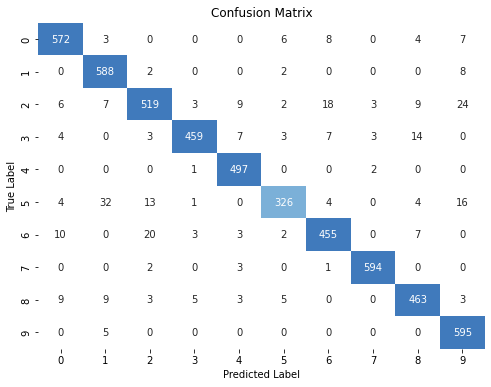

In [41]:
cm = confusion_matrix(labels, predictions)
print("Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap=['#FFFFFF', '#7BB0D8', '#407ABC'], cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [42]:
shutil.rmtree('train_temp')
shutil.rmtree('test_temp')